### check params of the swot pixc data, for river

In [9]:
import os
import xarray as xr
from glob import glob
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
from utils.functions import swot_raster_reproj
from utils.swot_data_mask import swot_pixc_mask


In [4]:
path_pixc = 'data/jinsha-river/pixc/SWOT_L2_HR_PIXC_009_383_202R_20240117T194047_20240117T194058_PIC0_01.nc'
path_raster = 'data/jinsha-river/raster/SWOT_L2_HR_Raster_100m_UTM47R_N_x_x_x_009_383_101F_20240117T194037_20240117T194058_PIC0_01.nc'
path_river_vec = 'data/jinsha-river/jinsha_vector.gpkg'  ## vectorization by manual
path_rsimg = 'data/rsimg/jinsha_s2_20240302_wgs84.tif'
path_river_centerline_vec = 'data/jinsha-river/jinsha_sword_reaches_v16.gpkg'


In [5]:
## read rsimg 
rsimg_rio = rio.open(path_rsimg)
## read vector file of the lake.
river_gpd = gpd.read_file(path_river_vec).to_crs(epsg=4326)
river_gpd
## read river centerline.
river_centerline_gpd = gpd.read_file(path_river_centerline_vec)
river_centerline_gpd.head(2)


,x,y,reach_id,reach_len,n_nodes,wse,wse_var,width,width_var,facc,...,n_rch_dn,rch_id_up,rch_id_dn,swot_orbit,swot_obs,type,river_name,edit_flag,trib_flag,geometry
0,100.067262,27.040321,43499300101,18047.262655,90,1808.099976,0.057228,192.0,1218.938875,214776.753850,...,1,43499300111,43499300091,383 424,2,1,Jinsha River,NaN,0,"LINESTRING (100.05432 27.11296, 100.05438 27.1..."
1,100.015912,26.908294,43499300111,19321.613073,97,1808.099976,1.535153,258.0,11675.897623,214034.512051,...,1,43499300121,43499300101,383,1,1,Jinsha River,NaN,0,"LINESTRING (100.05774 26.96858, 100.05762 26.9..."


In [ ]:
pixc_nc = xr.open_dataset(path_pixc, group='pixel_cloud')
raster_nc = xr.open_dataset(path_raster, decode_times=False)
pixc_nc


<xarray.Dataset>
Dimensions:                                (points: 3131569, complex_depth: 2,
                                            num_pixc_lines: 3286)
Coordinates:
    latitude                               (points) float64 ...
    longitude                              (points) float64 ...
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 ...
    range_index                            (points) float64 ...
    interferogram                          (points, complex_depth) float32 ...
    power_plus_y                           (points) float32 ...
    power_minus_y                          (points) float32 ...
    coherent_power                         (points) float32 ...
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 ...
    pixc_line_to_tvp                       (num_pixc_lines) float32 ...
    data_window_first_valid                (num_pixc_lines) float64 ...
    data_window_last_valid                 (num_pixc_lines) float64 ...
    data_window_first_cross_track          (num_pixc_lines) float32 ...
    data_window_last_cross_track           (num_pixc_lines) float32 ...
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3286
    interferogram_size_range:    6395
    looks_to_efflooks:           1.5546233107040275
    num_azimuth_looks:           7.0
    azimuth_offset:              3

In [10]:
raster_epsg = '326' + str(raster_nc.attrs['utm_zone_num'])
raster_wgs84_nc = swot_raster_reproj(raster_nc, epsg_from=raster_epsg, epsg_to='4326')
# Calculate the extent of the raster_wgs84_nc using its coordinates
xmin, xmax = raster_wgs84_nc.x.min().item(), raster_wgs84_nc.x.max().item()
ymin, ymax = raster_wgs84_nc.y.min().item(), raster_wgs84_nc.y.max().item()
raster_extent = [xmin, xmax, ymin, ymax]
raster_extent


[98.74175472924054, 100.24418373936369, 26.1768101643078, 27.520585729341605]

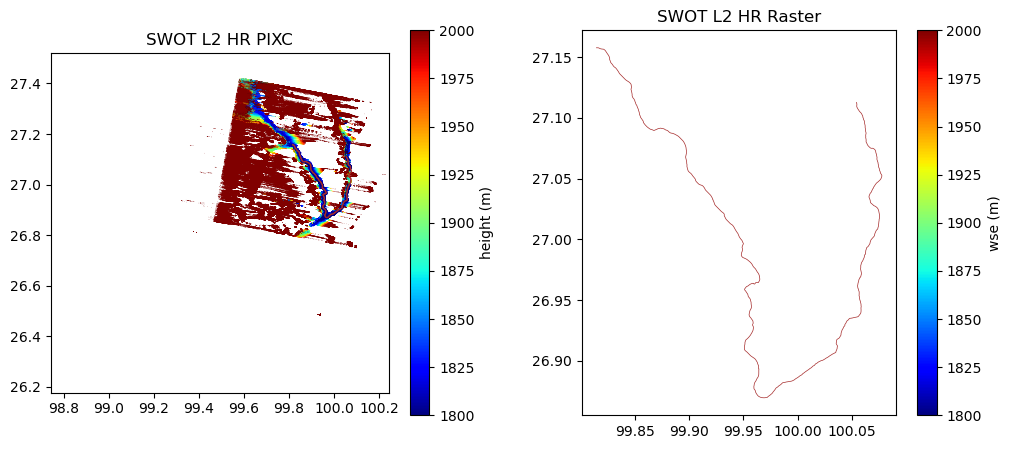

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# ax1  
scat1 = ax[0].scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_nc.height,
                            s=0.1, edgecolor='none', cmap='jet', clim=(1800, 2000))
river_centerline_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=0.5)
ax[0].set_title('SWOT L2 HR PIXC')
# ax2  
im1 = ax[0].imshow(raster_wgs84_nc.wse.values, 
                   cmap='jet', extent=raster_extent, vmax=2000, vmin=1800)
river_centerline_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
ax[1].set_title('SWOT L2 HR Raster')
fig.colorbar(scat1, ax=ax[0]).set_label('height (m)')
fig.colorbar(im1, ax=ax[1]).set_label('wse (m)')


Text(0.5, 1.0, 'SWOT L2 HR Raster')

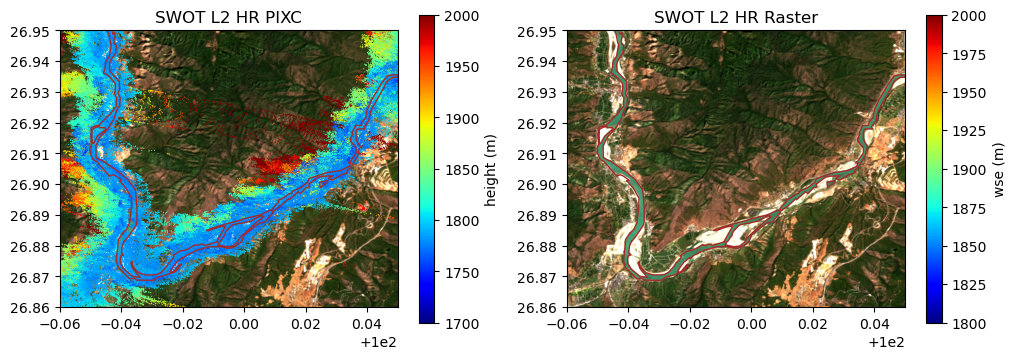

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# ax1
scat1 = ax[0].scatter(x=pixc_nc.longitude, y=pixc_nc.latitude, c=pixc_nc.height,
           s=0.5, edgecolor='none', cmap='jet', clim=(1700, 2000))
river_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
show(rsimg_rio, ax=ax[0], indexes=[3, 2, 1], percent_range=[2,98])  # RGB bands for Sentinel-2
ax[0].set_xlim([99.94, 100.05]) 
ax[0].set_ylim([26.86, 26.95])
ax[0].set_title('SWOT L2 HR PIXC')
# ax2
im2 = ax[1].imshow(raster_wgs84_nc.wse.values, 
                   cmap='jet', extent=raster_extent, vmax=2000, vmin=1800)
river_gpd.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
fig.colorbar(scat1, ax=ax[0]).set_label('height (m)')
fig.colorbar(im2, ax=ax[1]).set_label('wse (m)')
show(rsimg_rio, ax=ax[1], indexes=[3, 2, 1], percent_range=[2,98])  ## RGB bands for Sentinel-2
ax[1].set_xlim([99.94, 100.05])
ax[1].set_ylim([26.86, 26.95])
ax[1].set_title('SWOT L2 HR Raster')
